In [5]:
import numpy.random as rnd
import numpy as np
import os
import sys

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [6]:
#for plotting generated images (will be used later in notebook)
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")


In [7]:
#using an autoencoder for Principal Component Analysis
#because the model learns an lower dimensional internal state but outputs a larger tensor (size of input), it must learn
#the important features

#build 3d dataset
rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data= np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [9]:
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
n_iterations = 100 
codings = hidden


In [12]:
with tf.Session() as sess:
    init.run()
    for iteration in range (n_iterations):
        training_op.run(feed_dict={X:X_train})
        
    codings_val = codings.eval(feed_dict={X: X_test})

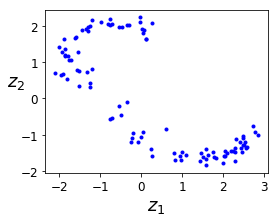

In [13]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [28]:
#stacked autoencoder - similar construction as regular DNNS

reset_graph()

from functools import partial 

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 #codings layer
n_hidden3 = 300
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init =  tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=he_init, kernel_regularizer=l2_regularizer)

with tf.name_scope("Autoencoder_dnn"):
    hidden1 = dense_layer(X, n_hidden1)
    hidden2 = dense_layer(hidden1, n_hidden2)
    hidden3 = dense_layer(hidden2, n_hidden3)
    outputs = dense_layer(hidden3, n_outputs, activation=None)
    
with tf.name_scope("loss"):
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
    
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([reconstruction_loss] + reg_losses)
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 5
batch_size = 150


In [29]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./AutoEncoder.ckpt")                  

0 Train MSE: 0.024103638
1 Train MSE: 0.013435125
2 Train MSE: 0.010993243
3 Train MSE: 0.010324679
4 Train MSE: 0.009631201


In [30]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./AutoEncoder.ckpt


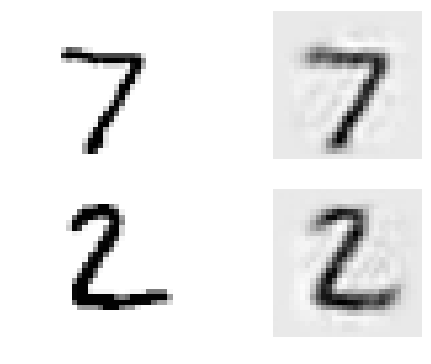

In [31]:
file_writer= tf.summary.FileWriter("tf_logs/AutoEncoder", tf.get_default_graph())
show_reconstructed_digits(X, outputs, "./AutoEncoder.ckpt")

In [32]:
#tying the weights of the encoder/decoder layers together is a common practice to increase speed/ reduce overfitting

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [41]:
#this is rather verbose but can make a big difference for large datasets

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
init = tf.global_variables_initializer()

saver= tf.train.Saver()

n_epochs=10
batch_size=150

In [42]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./AutoEncoderTiedWeights.ckpt")
            

0 Train MSE: 0.032421026
1 Train MSE: 0.028348109
2 Train MSE: 0.026844747
3 Train MSE: 0.02681761
4 Train MSE: 0.027302021
5 Train MSE: 0.027280593
6 Train MSE: 0.025982508
7 Train MSE: 0.025065375
8 Train MSE: 0.024845198
9 Train MSE: 0.026249574


INFO:tensorflow:Restoring parameters from ./AutoEncoderTiedWeights.ckpt


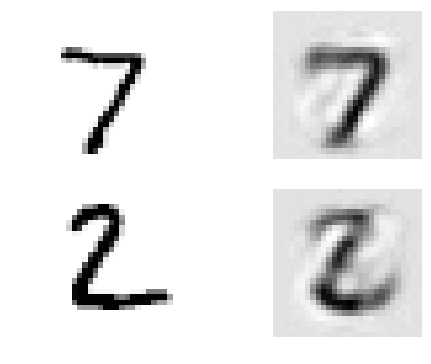

In [44]:
show_reconstructed_digits(X, outputs, "./AutoEncoderTiedWeights.ckpt")

In [49]:
#training Autoencoders piece by piece (ie. training the an autoencoder with just one hidden and input + output, 
#then using the data from the hidden as the in put for another autoencoder with the same structure)

#using multiple graphs
reset_graph()

from functools import partial 

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size, learning_rate= 0.01, l2_reg= 0.0005, seed=42,
                      hidden_activation=tf.nn.elu, output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        
        tf.set_random_seed(seed)
        n_inputs = X_train.shape[1]
        
        X=tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        dense_layer = partial(tf.layers.dense, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))
        
        hidden = dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")
        
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
        reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_loss)
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train Mse:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_batch})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [50]:
#exterior layers (takes original dataset as input)
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=5, batch_size=150, output_activation=None)

0 Train Mse: 0.01912159
1 Train Mse: 0.018708097
2 Train Mse: 0.019261027
3 Train Mse: 0.01967298
4 Train Mse: 0.019353429


In [51]:
#interior layers (takes hidden1 as input)

_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=5, batch_size=150)

0 Train Mse: 0.20882949
1 Train Mse: 0.13271101
2 Train Mse: 0.093922116
3 Train Mse: 0.072260156
4 Train Mse: 0.058027912


In [52]:
#create full autoencoder by using the weights and biases just trained
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

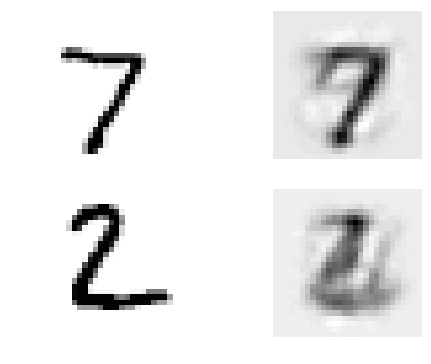

In [53]:
show_reconstructed_digits(X, outputs)

In [54]:
#training piece by piece using only 1 graph 
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)


In [55]:
#training phases that act like the two seperate graphs from last net
with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    phase1_recon_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_recon_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)
    
with tf.name_scope("phase2"):
    phase2_recon_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_recon_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list = train_vars)
    

In [58]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_recon_loss, phase2_recon_loss]
n_epochs = [5, 5]
batch_sizes = [150, 150]

In [60]:
with tf.Session() as sess: 
    init.run()
    for phase in range(2):
        print("training phase #{}".format(phase + 1))
        for epoch in range (n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X:X_batch})
            print("\r{}".format(epoch), "train mse:", loss_train)
            saver.save(sess, "./AutoEncoder_1G_PieceBy.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("test mse:", loss_test)

training phase #1
0 train mse: 0.0074308594
1 train mse: 0.00803159
2 train mse: 0.007537833
3 train mse: 0.007623723
4 train mse: 0.007917441
training phase #2
0 train mse: 0.03210683
1 train mse: 0.0031614855
2 train mse: 0.0022429542
3 train mse: 0.0018942725
4 train mse: 0.0018177711
test mse: 0.009885036


In [61]:
file_writer= tf.summary.FileWriter("tf_logs/AutoEncoder_1G_P", tf.get_default_graph())

In [68]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_recon_loss, phase2_recon_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./Auto_1G_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.007569033
1 Train MSE: 0.0076020216
2 Train MSE: 0.007828681
3 Train MSE: 0.00776155
Training phase #2
0 Train MSE: 0.19458014
1 Train MSE: 0.003761015
2 Train MSE: 0.002491628
3 Train MSE: 0.0019988513
Test MSE: 0.009696062


INFO:tensorflow:Restoring parameters from ./AutoEncoder_1G_PieceBy.ckpt


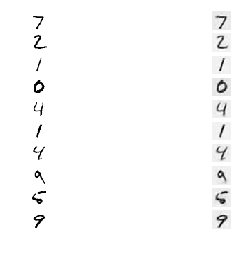

In [64]:
#visualizing some reconstructions
n_test_digits=10
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./AutoEncoder_1G_PieceBy.ckpt")
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./AutoEncoder_1G_PieceBy.ckpt


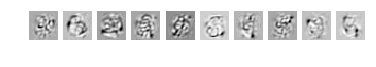

In [66]:
with tf.Session() as sess:
    saver.restore(sess, "./AutoEncoder_1G_PieceBy.ckpt")
    weights1_val = weights1.eval()
    
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plot_image(weights1_val.T[i])
    
plt.show()
    

In [71]:
#unsupervised pretraining for classification

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300 
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X=tf.placeholder(tf.float32, shape=[None, n_inputs])
y= tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [75]:
#training reusing pretrained/ cached layers
n_epochs=10
batch_size = 150 
n_labeled_instances=20000

training_op = optimizer.minimize(loss, var_list=[weights3, biases3]) #freeze pretrained layers (1 and 2)

with tf.Session() as sess: 
    init.run()
    pretrain_saver.restore(sess, "./Auto_1G_cache_frozen.ckpt" )
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("test acc", accuracy_val)

INFO:tensorflow:Restoring parameters from ./Auto_1G_cache_frozen.ckpt
0 Train accuracy: 0.9	test acc 0.8932
1 Train accuracy: 0.9066667	test acc 0.9029
2 Train accuracy: 0.92	test acc 0.9038
3 Train accuracy: 0.9266667	test acc 0.9088
4 Train accuracy: 0.92	test acc 0.9075
5 Train accuracy: 0.9066667	test acc 0.9109
6 Train accuracy: 0.93333334	test acc 0.9108
7 Train accuracy: 0.9	test acc 0.9104
8 Train accuracy: 0.91333336	test acc 0.9129
9 Train accuracy: 0.9066667	test acc 0.9131


In [80]:
#using a stacked autoencoder as a denoiser 
reset_graph()


n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

#dropout 

dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)


#adding gaussian noise
#noise_level = 1.0

#X = tf.placeholder(tf.float32, shape=[None, n_inputs])
#adding some noise to data to demostrate denoising
#X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden2, activation=tf.nn.relu, name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, activation=tf.nn.relu, name="outputs")

recon_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(recon_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 10
batch_size = 150


In [81]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = recon_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)

0 Train MSE: 0.023665417
1 Train MSE: 0.019810345
2 Train MSE: 0.020515598
3 Train MSE: 0.01928169
4 Train MSE: 0.019746142
5 Train MSE: 0.017727878
6 Train MSE: 0.020024894
7 Train MSE: 0.019440617
8 Train MSE: 0.019204002
9 Train MSE: 0.019257396


[0, 1, 0, 0.95]

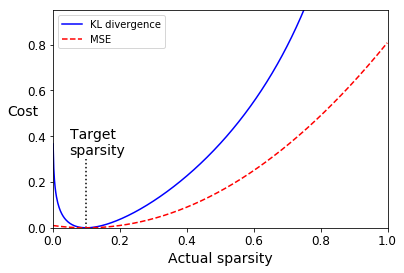

In [83]:
#keeping your autoencoder sparse (learns more important features, reduces overfitting)
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [87]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

def kl_divergence(p, q):
    #Kullback Leibler Divergence
    return p * tf.log(p/q) + (1-p) * tf.log((1-p) / (1- q))

learning_rate = 0.01
sparsity_target = 0.1
#weight too high = too sparse, learns no features. too low = not sparse enough 
sparsity_weight = 0.2

X= tf.placeholder(tf.float32, shape=[None, n_inputs])

#using sigmoid is crucial because activations must be between 0 and 1 (but not equal to)
# or kullback-leibler divergence will return NaN
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1, n_outputs)

hidden1_mean= tf.reduce_mean(hidden1, axis=0) #batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
recon_loss = tf.reduce_mean(tf.square(outputs - X)) #MSE
loss = recon_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 100
batch_size = 1000



In [88]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([recon_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)

0 Train MSE: 0.13508767 	Sparsity loss: 0.3811443 	Total loss: 0.21131653
1 Train MSE: 0.05908208 	Sparsity loss: 0.029987127 	Total loss: 0.0650795
2 Train MSE: 0.05126447 	Sparsity loss: 0.15392905 	Total loss: 0.08205028
3 Train MSE: 0.049341507 	Sparsity loss: 0.26176748 	Total loss: 0.101695
4 Train MSE: 0.04513889 	Sparsity loss: 0.06525828 	Total loss: 0.058190547
5 Train MSE: 0.04129143 	Sparsity loss: 0.015824992 	Total loss: 0.04445643
6 Train MSE: 0.03919443 	Sparsity loss: 0.13645639 	Total loss: 0.06648571
7 Train MSE: 0.03641217 	Sparsity loss: 0.03638574 	Total loss: 0.043689318
8 Train MSE: 0.03422003 	Sparsity loss: 0.07850471 	Total loss: 0.04992097
9 Train MSE: 0.03011092 	Sparsity loss: 0.033096783 	Total loss: 0.036730275
10 Train MSE: 0.027138721 	Sparsity loss: 0.01976406 	Total loss: 0.031091534
11 Train MSE: 0.025142947 	Sparsity loss: 0.066904396 	Total loss: 0.038523827
12 Train MSE: 0.023716083 	Sparsity loss: 0.0475564 	Total loss: 0.03322736
13 Train MSE: 

In [111]:
#variational autoencoder
#probabalistic autoencoder: outputs are partially determined by chance, even after training
#can generate new instances that look like they came form the dataset
#instead of directly producing a coding, a men coding and a standard deviation are produced
# the actual coding is sampled from a gaussian distribution with the mean std. dev. produced

reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20 #codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

learning_rate= 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=initializer)
X = tf.placeholder(tf.float32, [None, n_inputs])

with tf.name_scope("Variational_autoencoder"):
    hidden1= dense_layer(X, n_hidden1)
    hidden2= dense_layer(hidden1, n_hidden2)
    hidden3_mean = dense_layer(hidden2, n_hidden3, activation=None)
    hidden3_gamma = dense_layer(hidden2, n_hidden3, activation=None)
    #hidden3_sigma = dense_layer(hidden2, n_hidden3, activation=None)
    noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
    hidden3 = hidden3_mean + hidden3_gamma * noise
    hidden4 = dense_layer(hidden3, n_hidden4)
    hidden5 = dense_layer(hidden4, n_hidden5)
    logits = dense_layer(hidden5, n_outputs, activation=None)
    outputs = tf.sigmoid(logits)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
    reconstruction_loss = tf.reduce_sum(xentropy)

    #eps = 1e-10 # smoothing term to prevent computing log(0) (NaN)
    #latent_loss = 0.5 * tf.reduce_sum(tf.square(hidden3_sigma) + tf.square(hidden3_mean) - 1 - tf.log(eps + tf.square(hidden3_sigma)))
    
    #latent loss that computes log(stddev^2) rather than just tddev
    #speeds up convergence and makes it easier to capture sigmas of different scales
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
    
    loss = reconstruction_loss + latent_loss
        
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 50
batch_size = 150
    

In [112]:
with tf.Session() as sess: 
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./Variational_auto.ckpt")

0 Train total loss: 14505.454 	Reconstruction loss: 13869.736 	Latent loss: 635.71765
1 Train total loss: 12423.798 	Reconstruction loss: 11911.741 	Latent loss: 512.0563
2 Train total loss: 11737.649 	Reconstruction loss: 11314.842 	Latent loss: 422.8077
3 Train total loss: 11584.393 	Reconstruction loss: 11200.336 	Latent loss: 384.05707
4 Train total loss: 11807.73 	Reconstruction loss: 11447.514 	Latent loss: 360.2165
5 Train total loss: 10774.763 	Reconstruction loss: 10423.988 	Latent loss: 350.77484
6 Train total loss: 11084.633 	Reconstruction loss: 10770.99 	Latent loss: 313.643
7 Train total loss: 11022.707 	Reconstruction loss: 10713.914 	Latent loss: 308.7932
8 Train total loss: 11252.133 	Reconstruction loss: 10947.204 	Latent loss: 304.92892
9 Train total loss: 11133.772 	Reconstruction loss: 10837.295 	Latent loss: 296.47766
10 Train total loss: 10249.847 	Reconstruction loss: 9970.238 	Latent loss: 279.60834
11 Train total loss: 10308.118 	Reconstruction loss: 10023.476

In [117]:
file_writer= tf.summary.FileWriter("tf_logs/AutoEncoder_Variational", tf.get_default_graph())

In [114]:

import numpy as np

n_digits = 60
saver= tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./Variational_auto.ckpt")
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})


INFO:tensorflow:Restoring parameters from ./Variational_auto.ckpt


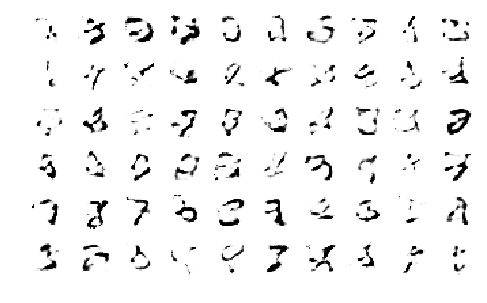

In [115]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

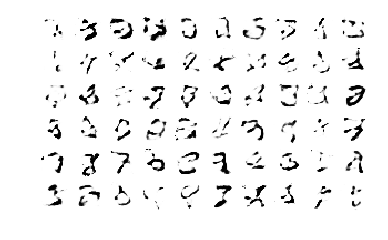

In [116]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
plt.show()
